In [5]:
using CairoMakie
using Roots
using Base.Threads
using GeometryBasics: Point2f
using ProgressMeter   


println("Enter the value of γ : ")
γ = parse(Float64, readline())

if γ > 2 || γ <= 1
    error("Unphysical Adiabatic Constant")
end




c = 1.0
N = 500
L = 1.0
L_mid = L / 2
N_mid = N / 2
x = LinRange(0, L, N)
dx = L / N
dt = 0.0
T = 0.375
CFL = 0.01




function initial_condition(x)
    ρ, v, p = x < L_mid ?   (10.0,0.0,13*(1/3)) : (1.0,0.0,(2/3)*(10^-6)) #(1.0,0,1000.0) : (1.0,0,0.01) # (10.0,0.0,13*(1/3)) : (1.0,0.0,(2/3)*(10^-6))  # 
    
    W = 1 / sqrt(1 - v^2)
    e = (p / (γ - 1)) + ρ
    D = ρ * W
    S = (e + p) * W^2 * v
    E = (e + p) * W^2 - p
    return [D, S, E]
end





function p_func(v, D, S, E)
    e = E - v * S
    n = D * sqrt(1 - v^2)
    return [(γ - 1) * (e - n), n, e]
end




function pressure_nu(U)
    D, S, E = U
    δ = 1e-6
    g(v) = v * (E + p_func(v, D, S, E)[1]) - S
    vl, vu = -0.999999, 0.999999
    f_vl, f_vu = g(vl), g(vu)

    if f_vl * f_vu > 0
        #println("Root not bracketed, fallback failed. Assigning vroot = 0.0")
        vroot = 0.0
    else
        vroot = find_zero(g, (vl, vu), method=:brent, atol=1e-8)
    end

    p_val, n_val, e_val = p_func(vroot, D, S, E)
    return [p_val, vroot, n_val, e_val]
end




function flux(U)
    D, S, E = U
    p, v = pressure_nu(U)[1:2]
    return [v * D, v * S + p, (p + E) * v]
end



function relativistic_hlle_flux(U_L, U_R)
    δ = 1e-12
    p_L, v_L, n_L, e_L = pressure_nu(U_L)
    p_R, v_R, n_R, e_R = pressure_nu(U_R)
    p_L, p_R = max(δ, p_L), max(δ, p_R)
    #e_n_L, e_n_R = e_L - n_L, e_R - n_R
    e_n_L = max(δ,e_L - n_L) 
    e_n_R = max(δ,e_R - n_R)
    #c_s_L_2 = max((γ*(γ - 1)*e_n_L)/(n_L + γ*e_n_L), (γ * p_L)/(n_L + p_L + e_L))
    #c_s_R_2 = max((γ*(γ - 1)*e_n_R)/(n_R + γ*e_n_R), (γ * p_R)/(n_R + p_R + e_R))
    c_s_L_2 = (γ*(γ - 1)*e_n_L)/(n_L + γ*e_n_L)
    c_s_R_2 = (γ*(γ - 1)*e_n_R)/(n_R + γ*e_n_R)
    
    c_s_L, c_s_R = sqrt(c_s_L_2), sqrt(c_s_R_2)
    v_M = (sqrt(U_L[3])*v_L + sqrt(U_R[3])*v_R)/(sqrt(U_L[3]) + sqrt(U_R[3]))
    c_s_M_2 = (sqrt(U_L[3])*c_s_L_2 + sqrt(U_R[3])*c_s_R_2) / (sqrt(U_L[3]) + sqrt(U_R[3])) + ((v_R - v_L)^2)*((γ - 1)/2) * (sqrt(U_L[3] * U_R[3])/(U_R[3] + U_R[3])^2)
    c_s_M = sqrt(c_s_M_2)
    λ_L = min(0, (v_M - c_s_M) / (1 - v_M * c_s_M), (v_L - c_s_L) / (1 - v_L * c_s_L))
    λ_R = max(0, (v_M + c_s_M) / (1 + v_M * c_s_M), (v_R + c_s_R) / (1 + v_R * c_s_R))
    F_L, F_R = flux(U_L), flux(U_R)
    λ_L >= 0 && return F_L
    λ_R <= 0 && return F_R
    return (λ_R * F_L - λ_L * F_R + λ_L * λ_R * (U_R .- U_L)) / (λ_R - λ_L)
end



# --- add this helper -----------------------------------------
function max_signal_speed(U)  # max over |λ±| = |(v ± c_s)/(1 ± v c_s)|
    smax = 1e-12
    for i in 1:length(U)
        p, v, n, e = pressure_nu(U[i])
        e_n = max(1e-12, e - n)
        cs2 = (γ*(γ - 1)*e_n) / (n + γ*e_n)
        cs2 = clamp(cs2, 0.0, 1 - 1e-12)
        cs  = sqrt(cs2)
        sL  = abs((v - cs) / (1 - v*cs))
        sR  = abs((v + cs) / (1 + v*cs))
        smax = max(smax,sL, sR)
    end
    return smax
end





function minmod_slope_limiter(U)
    NC = length(U) - 2
    UL, UR = deepcopy(U), deepcopy(U)
    for j in 2:NC+1
        sp, sm = U[j+1] .- U[j], U[j] .- U[j-1]
        dU = 0.25 .* (sign.(sp) .+ sign.(sm)) .* min.(abs.(sp), abs.(sm))
        UL[j], UR[j-1] = U[j] .+ dU, U[j] .- dU
    end
    return UL, UR
end





U = [initial_condition(xi) for xi in x]
U_half_L = deepcopy(U)
U_half_R = deepcopy(U)
U_new = deepcopy(U)
t = 0.0


# compute a safe initial dt and steps BEFORE creating Progress
speed0 = max_signal_speed(U)
global dt     = CFL * dx / max(speed0, 1e-12)
steps  = ceil(Int, T / dt)
p      = Progress(steps, 1, "Simulating...", 50)


#steps = Int(round(T / dt))
#p = Progress(steps, 1, "Simulating...", 50)   


# Thread-safe printing from threaded loops
const LOG_LOCK = ReentrantLock()

# Enforce E >= max(D,S) by nudging E upward if needed
@inline function enforce_energy!(U::AbstractVector{T}; where::AbstractString="", idx::Int=-1, t::Float64=NaN) where {T<:AbstractFloat}
    D, S, E = U
    ΔED = E - D
    ΔES = E - S
    minmargin = min(ΔED, ΔES)
    if minmargin < 0.0
        δE = -minmargin + 1e-6  # amount to add to E
        U[3] = E + δE
        lock(LOG_LOCK) do
            #println("Energy fix ($where) at t=$(t), i=$(idx): ΔE = $(δE)   (E-D=$(ΔED), E-S=$(ΔES))")
        end
    end
    return nothing
end

# ---- time stepping ----
while t <= T
    dt = CFL * dx / max(max_signal_speed(U), 1e-12)

    UL, UR = minmod_slope_limiter(U)

    @threads for i in 2:N-1
        FL, FR = flux(UL[i]), flux(UR[i])
        U_half_L[i] = UL[i] .- 0.5 * (dt / dx) .* (FR .- FL)
        U_half_R[i] = UR[i] .- 0.5 * (dt / dx) .* (FR .- FL)

        # Enforce constraints at half step (both sides)
        enforce_energy!(U_half_L[i]; where="predictor L", idx=i, t=t)
        enforce_energy!(U_half_R[i]; where="predictor R", idx=i, t=t)
    end

    @threads for j in 2:N-1
        F_L = relativistic_hlle_flux(U_half_L[j-1], U_half_R[j-1])
        F_R = relativistic_hlle_flux(U_half_L[j],   U_half_R[j])
        U_new[j] = U[j] .- (dt / dx) .* (F_R .- F_L)

        # Enforce constraints after full update
        enforce_energy!(U_new[j]; where="corrector", idx=j, t=t+dt)
    end

    # simple outflow BCs
    U_new[1], U_new[end] = U_new[2], U_new[end-1]

    U .= U_new
    global t += dt
    next!(p)
end




Enter the value of γ : 
stdin> 1.66


Simulating... 100%|██████████████████████████████████████████████████| Time: 0:03:09


In [6]:
D_final = [U[i][1] for i in 1:N]
p_final = [pressure_nu(U[i])[1] for i in 1:N]
v_final = [pressure_nu(U[i])[2] for i in 1:N]
n_final = [pressure_nu(U[i])[3] for i in 1:N]
e_final = [pressure_nu(U[i])[4] for i in 1:N];

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/iRM0c/src/scenes.jl:220


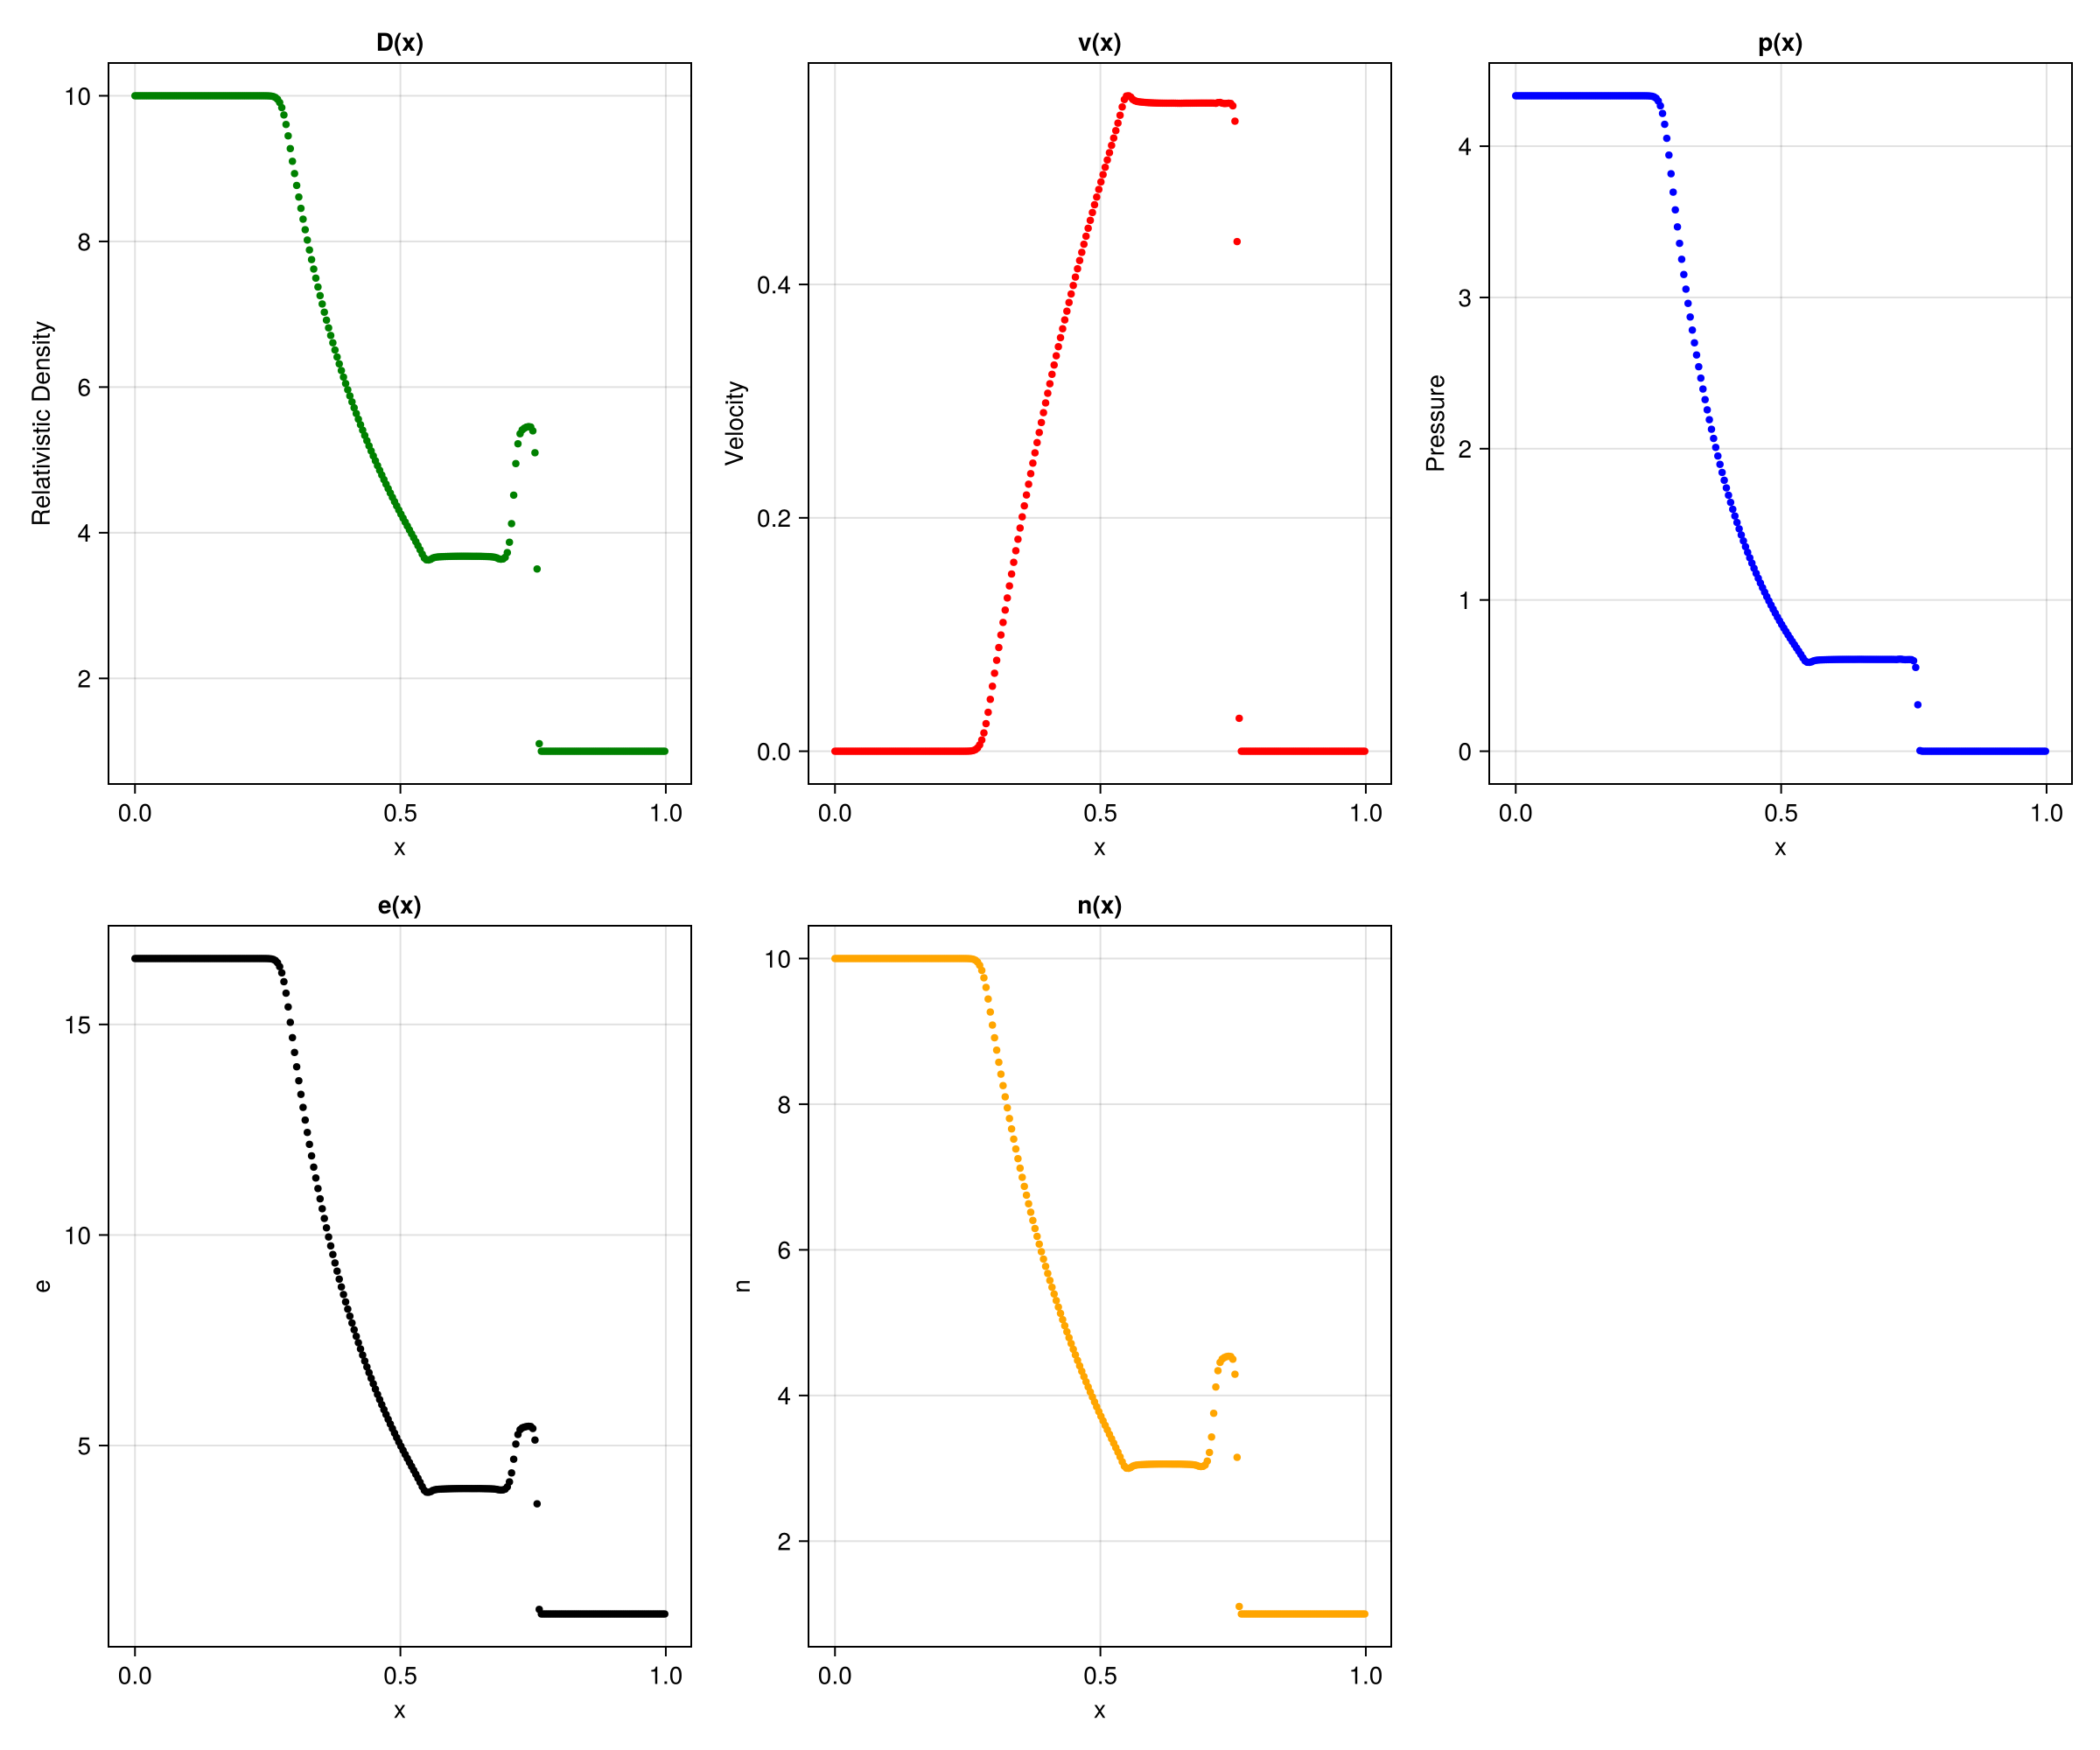

In [8]:
fig = Figure(resolution = (1200, 1000))
ax1 = Axis(fig[1, 1], xlabel="x", ylabel="Relativistic Density", title="D(x)")
ax2 = Axis(fig[1, 2], xlabel="x", ylabel="Velocity", title="v(x)")
ax3 = Axis(fig[1, 3], xlabel="x", ylabel="Pressure", title="p(x)")
ax4 = Axis(fig[2, 1], xlabel="x", ylabel="e", title="e(x)")
ax5 = Axis(fig[2, 2], xlabel="x", ylabel="n", title="n(x)")

scatter!(ax1, x[1:2:end], D_final[1:2:end], markersize=6,color = :green)
scatter!(ax2, x[1:2:end], v_final[1:2:end], markersize=6, color = :red)
scatter!(ax3, x[1:2:end], p_final[1:2:end], markersize=6, color = :blue)
scatter!(ax4, x[1:2:end], e_final[1:2:end], markersize=6, color = :black)
scatter!(ax5, x[1:2:end], n_final[1:2:end], markersize=6, color = :orange)


# scatter!(ax1, x[1:end], D_final[1:end], markersize=6,color = :green)
# scatter!(ax2, x[1:end], v_final[1:end], markersize=6, color = :red)
# scatter!(ax3, x[1:end], p_final[1:end], markersize=6, color = :blue)
# scatter!(ax4, x[1:end], e_final[1:end], markersize=6, color = :black)
# scatter!(ax5, x[1:end], n_final[1:end], markersize=6, color = :orange)

fig